### Importing all the libraries

In [7]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

### Preprocessing the Data

In [15]:
# get the perpendicular distance from the best fit line
def perpendicularDistance(x, y, m, c):
    ans = y-m*x+c
    ans /= (math.sqrt(m**2+1))
    return ans

# helper function to get the total number of traders
def getSize(fileName):
    dataFrame = pd.read_csv(fileName)
    Data = dataFrame.values
    print(Data.shape)
    foo = set(Data[:,0])
    totalSize = len(foo)
    return totalSize

# convert the whole data matrix into a new data matrix
# our new data matrix has different parameters entirely (~8)
def preprocessData(fileName):
    dataFrame = pd.read_csv(fileName)
    Data = dataFrame.values
#     attributes for which line needs to be fit
    CoPoints = [(2, 7), (7, 4), (4, 8), (2, 8), (7, 15), (15, 14)]
    reg = LinearRegression()
    finalData = []
    for foo in CoPoints:
        X = Data[:, foo[0]].reshape(-1,1)
        Y = Data[:, foo[1]].reshape(-1,1)
#         fitting the linear model
        reg.fit(X, Y)
        (Coef,Intercept) = ( reg.coef_ , reg.intercept_)
#        forming the dataMatrix
        temp = []
        for cnt in range(X.shape[0]):
            dis = perpendicularDistance(X[cnt][0], Y[cnt][0], Coef[0][0], Intercept[0])
            temp.append(dis)
        finalData.append(temp)
#  attributes for which ratio needs to be taken as a parameter
    RatioPoints = [(2, 15), (14, 15), (7, 14)]
    for foo in RatioPoints:
        X = Data[:, foo[0]].reshape(-1,1)
        Y = Data[:, foo[1]].reshape(-1,1)
        temp = []
        for cnt in range(len(X)):
            if Y[cnt][0]==0:
                temp.append(1e9)
            else :
                temp.append(X[cnt][0]/ Y[cnt][0])
        finalData.append(temp)
#   We get finalData matrix where each entry is having 9 parameters
    finalData = np.array(finalData)
    cnt = 0
    myData = []
    for cnt in range(finalData.shape[1]):
        myData.append(finalData[:,cnt])
    return np.array(myData)

# get Monthly parametrised data and also Monthly Id
def getMonthlyData(fileName, givenData):
    data = pd.read_csv(fileName)
    realData = data.values
    WholeData = {}
    DataId = {}
    MonthMap = { 72017: 1, 82017:2, 92017:3, 102017:4, 112017:5, 122017:6, 12018:7, 22018:8, 32018:9, 42018:10, 52018:11, 62018:12}
#     storing the dataIds for month in that
    for cnt in range(len(realData)):
        if realData[cnt][2] !=0:
            y = MonthMap[realData[cnt][1]]
            if y not in WholeData : 
                WholeData[y] = [givenData[cnt]]
                DataId[y] = [realData[cnt][0]]
            else :
                WholeData[y].append(givenData[cnt])
                DataId[y].append(realData[cnt][0])
    return (DataId, WholeData)

def getLowMonthlyData(fileName):
    data = pd.read_csv(fileName)
    realData = data.values
    WholeData = {}
    MonthMap = { 72017: 1, 82017:2, 92017:3, 102017:4, 112017:5, 122017:6, 12018:7, 22018:8, 32018:9, 42018:10, 52018:11, 62018:12}
#     storing the dataIds for month in that
    for cnt in range(len(realData)):
        if realData[cnt][2] !=0:
            y = MonthMap[realData[cnt][1]]
            if y not in WholeData : 
                WholeData[y] = [realData[cnt][2:]]
            else :
                WholeData[y].append(realData[cnt][2:])
# converting each month data into 2D data
    tsne = TSNE(n_components=2)
    for month in range(1, 13):
        WholeData[month] = np.array(WholeData[month])
        WholeData[month] = tsne.fit_transform(WholeData[month])
        print(WholeData[month].shape)
    return WholeData

### Retreiving Monthly Data

In [9]:
ParametricData = preprocessData('data_class.csv')
(DataId, WholeData) = getMonthlyData('data_class.csv', ParametricData)

### Calculation of Outliers using Spectral-Clustering

In [10]:
%%time
# Get the percentage of months where a guy is outlier.
def getOutlierCount(WholeData, DataId, clusterThreshold):
    OutlierPer = np.zeros(getSize('data_class.csv')+1)
    MonthlyClusters = {}
    MonthlyOutliers = {}
    for month in range(1, 13):
        MonthData = np.array(WholeData[month], dtype = np.float32)
        MonthIdData = np.array(DataId[month], dtype = np.int32)
        AdjacencyMatrix = cdist(MonthData, MonthData, 'correlation')
        clustering = SpectralClustering(n_clusters=10,
            assign_labels="discretize",
            random_state=0).fit(AdjacencyMatrix)    
        ClusterSize = {}
        for x in clustering.labels_:
            if x not in ClusterSize:
                ClusterSize[x] = 1
            else :
                ClusterSize[x] +=1 
        for x in ClusterSize:
            if month not in MonthlyClusters:
                MonthlyClusters[month] = [ClusterSize[x]]
            else : 
                MonthlyClusters[month].append(ClusterSize[x])
        for cnt, x in enumerate(clustering.labels_):
            if ClusterSize[x]<= clusterThreshold:
                if month not in MonthlyOutliers:
                    MonthlyOutliers[month] = [cnt]
                else :
                    MonthlyOutliers[month].append(cnt)
                OutlierPer[MonthIdData[cnt]] += 1
        print("Month ", month, " is completed")
    return (MonthlyOutliers, MonthlyClusters , np.array(OutlierPer))

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 12.6 µs


In [11]:
(MonthlyOutliers, MonthlyClusters, OutlierCount) = getOutlierCount(WholeData, DataId, 30)

(98310, 16)
Month  1  is completed
Month  2  is completed
Month  3  is completed
Month  4  is completed
Month  5  is completed
Month  6  is completed
Month  7  is completed
Month  8  is completed
Month  9  is completed
Month  10  is completed
Month  11  is completed
Month  12  is completed


### Final list of Suspicious Taxpayers

In [12]:
def getOutliers(OutlierCount, thresholdMonths) :
    Outliers = []
    totalClusters = getSize('data_class.csv')
    for foo in range(1, totalClusters):
        if OutlierCount[foo]>=thresholdMonths:
            Outliers.append(foo)
    return np.array(Outliers)

In [13]:
SuspiciousTaxPayers = getOutliers(OutlierCount, 1)

(98310, 16)


### Validation of suspicious tax-payers

In [16]:
# Plot 2D version of PCA version of original data
lowData = getLowMonthlyData('data_class.csv')

(6780, 2)
(7617, 2)
(7797, 2)
(7782, 2)
(7846, 2)
(7881, 2)
(7773, 2)
(7695, 2)
(7880, 2)
(7279, 2)
(7182, 2)
(6947, 2)


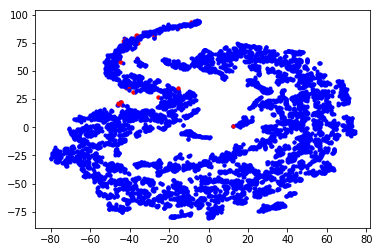

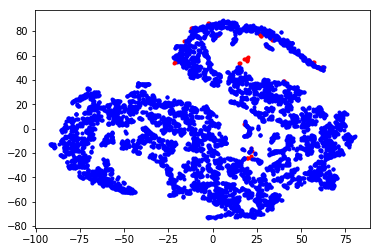

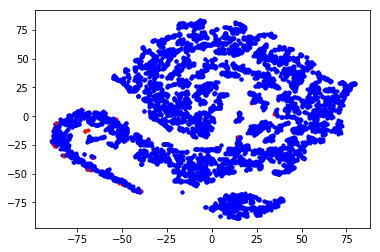

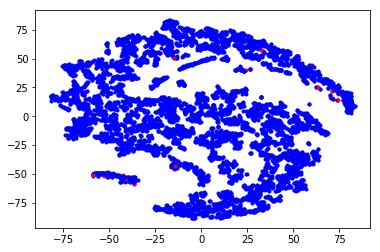

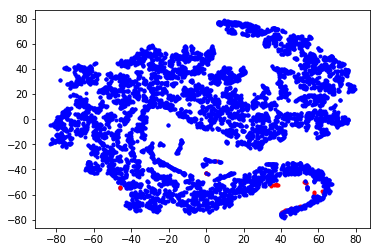

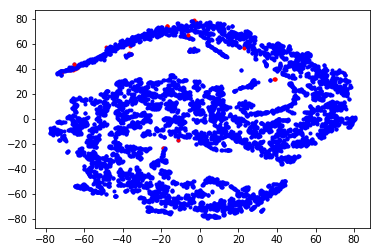

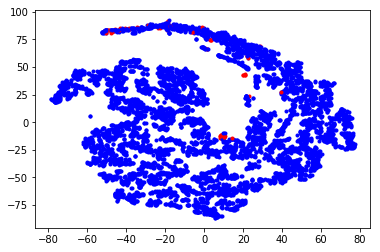

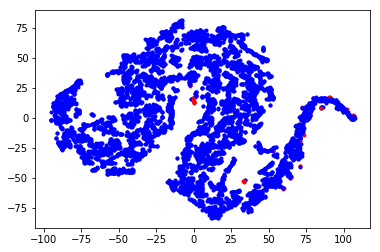

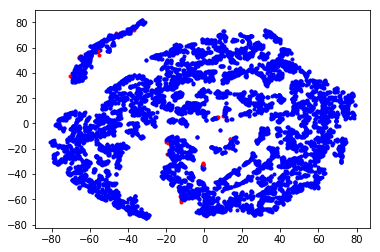

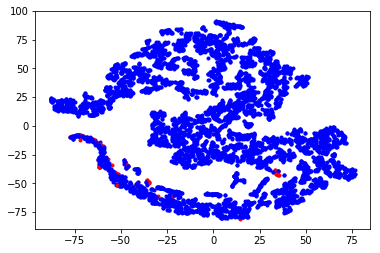

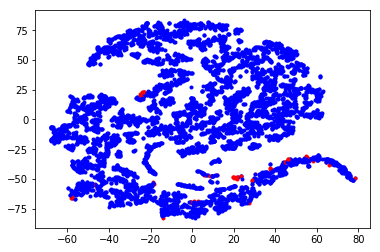

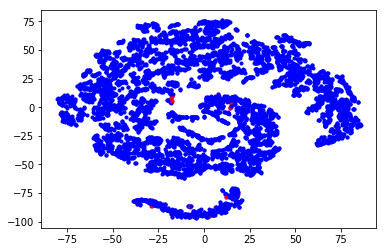

In [17]:
for month in lowData:
    temp = lowData[month]
#     plt.hold(True)
    for cnt, entry in enumerate(temp):
        if cnt in MonthlyOutliers[month]:
            plt.plot(entry[0], entry[1], 'r.')
        else : 
            plt.plot(entry[0], entry[1], 'b.')
    plt.show()

### Writing the suspicious Tax-payers to files

In [18]:
fileObject = open('Monthwise Clusters.txt', 'w+')
fileObject.write('Monthwise cluster sizes after applying Spectral Clustering \n')
for x in MonthlyClusters :
    fileObject.write('Month '+str(x)+': ')
    for y in MonthlyClusters[x] :
        fileObject.write(str(y)+", ")
    fileObject.write('\n')
fileObject.close()

In [19]:
fileObject = open('Suspicious Tax Payers.txt', 'w+')
for foo in SuspiciousTaxPayers:
    fileObject.write(str(foo) +', ')
fileObject.close()